In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install transformers==3

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.19.5
pandas 1.1.5
torch 1.7.0+cu101
transformers 3.0.0


In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
%cd "drive/My Drive/Colab Notebooks/experiments/data"
df = pd.read_csv("VUAsequence/vua_train.csv", encoding="ISO-8859-1")
df.head()

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/experiments/data'
/content/drive/My Drive/Colab Notebooks/experiments/data


,txt_id,sen_ix,sentence,label_seq,pos_seq,labeled_sentence,genre
0,a1k-fragment02,41,Ca n't fail to be entertaining .,"[0, 0, 0, 0, 0, 0, 0]","['VERB', 'ADV', 'VERB', 'PART', 'VERB', 'ADJ',...",Ca n't fail to be entertaining .,news
1,cdb-fragment04,907,How much was he going to tell her ?,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","['ADV', 'ADJ', 'VERB', 'PRON', 'VERB', 'PART',...",How much was he going to tell her ?,fiction
2,ac2-fragment06,1520,"Up until that news hit the Committee , Don had...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","['ADP', 'ADP', 'DET', 'NOUN', 'VERB', 'DET', '...","Up until M_that news M_hit the Committee , Don...",fiction
3,kbc-fragment13,5871,Could go on to the rugby and go with them coul...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","['VERB', 'VERB', 'PART', 'ADP', 'DET', 'NOUN',...",Could go on to the rugby and go with them coul...,conversation
4,ahb-fragment51,734,"Finally , we went to the office and they gave ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","['ADV', 'PUNCT', 'PRON', 'VERB', 'ADP', 'DET',...","Finally , we went to the office and M_they M_g...",news


In [ ]:
df.shape

(6323, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6323 entries, 0 to 6322
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   txt_id            6323 non-null   object
 1   sen_ix            6323 non-null   object
 2   sentence          6323 non-null   object
 3   label_seq         6323 non-null   object
 4   pos_seq           6323 non-null   object
 5   labeled_sentence  6323 non-null   object
 6   genre             6323 non-null   object
dtypes: object(7)
memory usage: 345.9+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


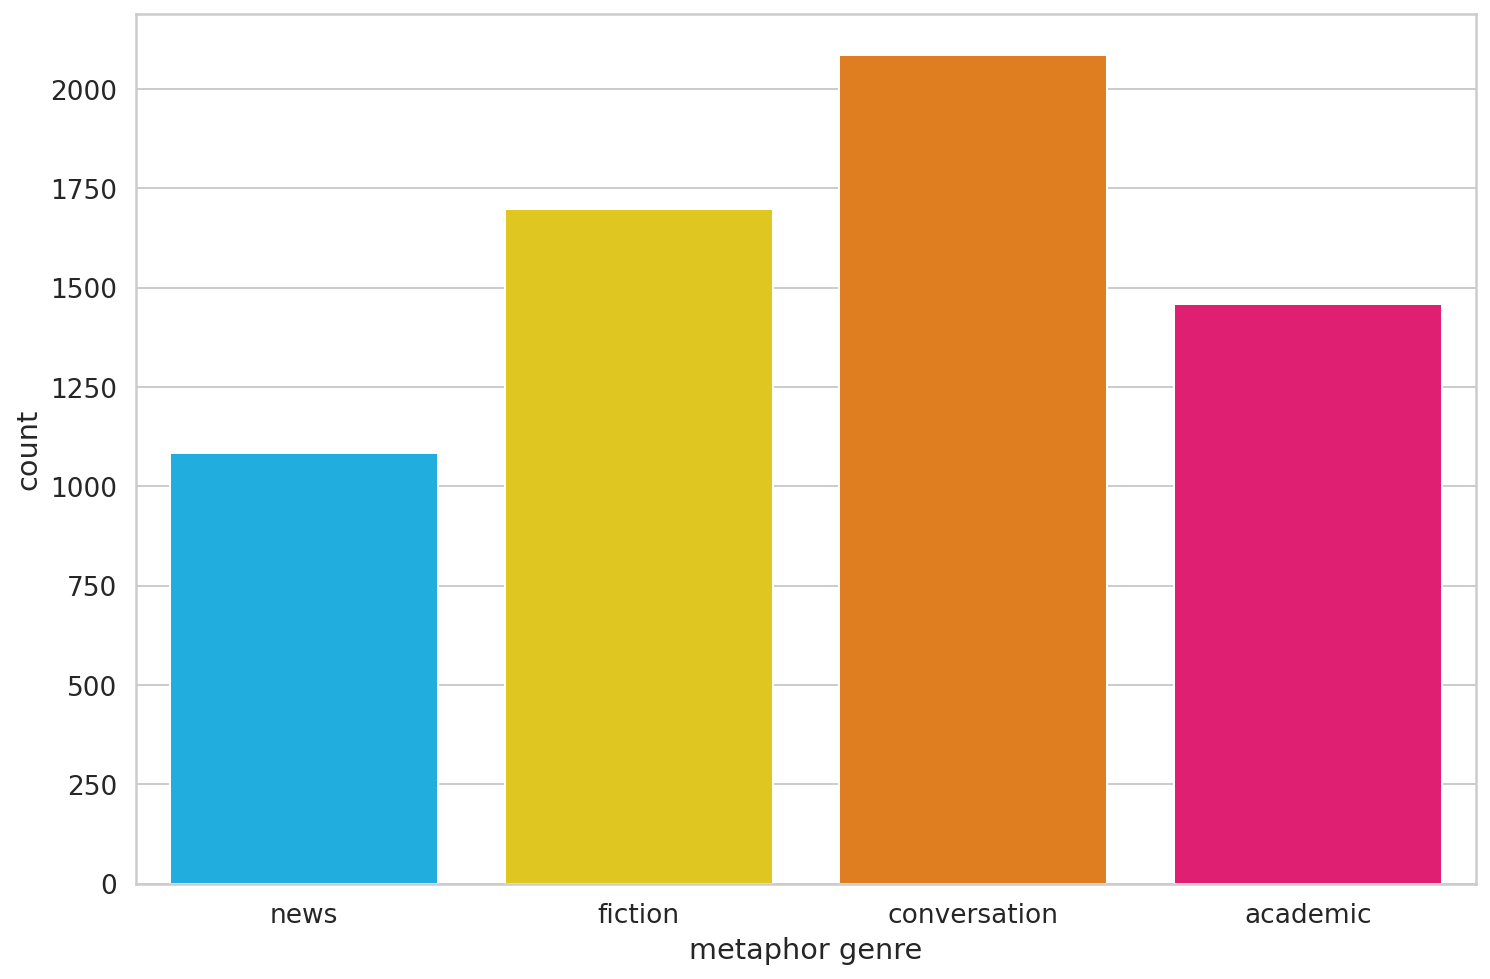

In [ ]:
sns.countplot(df.genre)
plt.xlabel('metaphor genre');

In [ ]:
def genre_multiclass(genre):
  genre = str(genre)
  if genre == "news":
    return 0
  elif genre == "fiction":
    return 1
  elif genre == "conversation": 
    return 2
  elif genre == "academic":
    return 3

df['genre_mc'] = df.genre.apply(genre_multiclass)

In [ ]:
class_names = ['news', 'fiction', 'conversation', 'academic']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


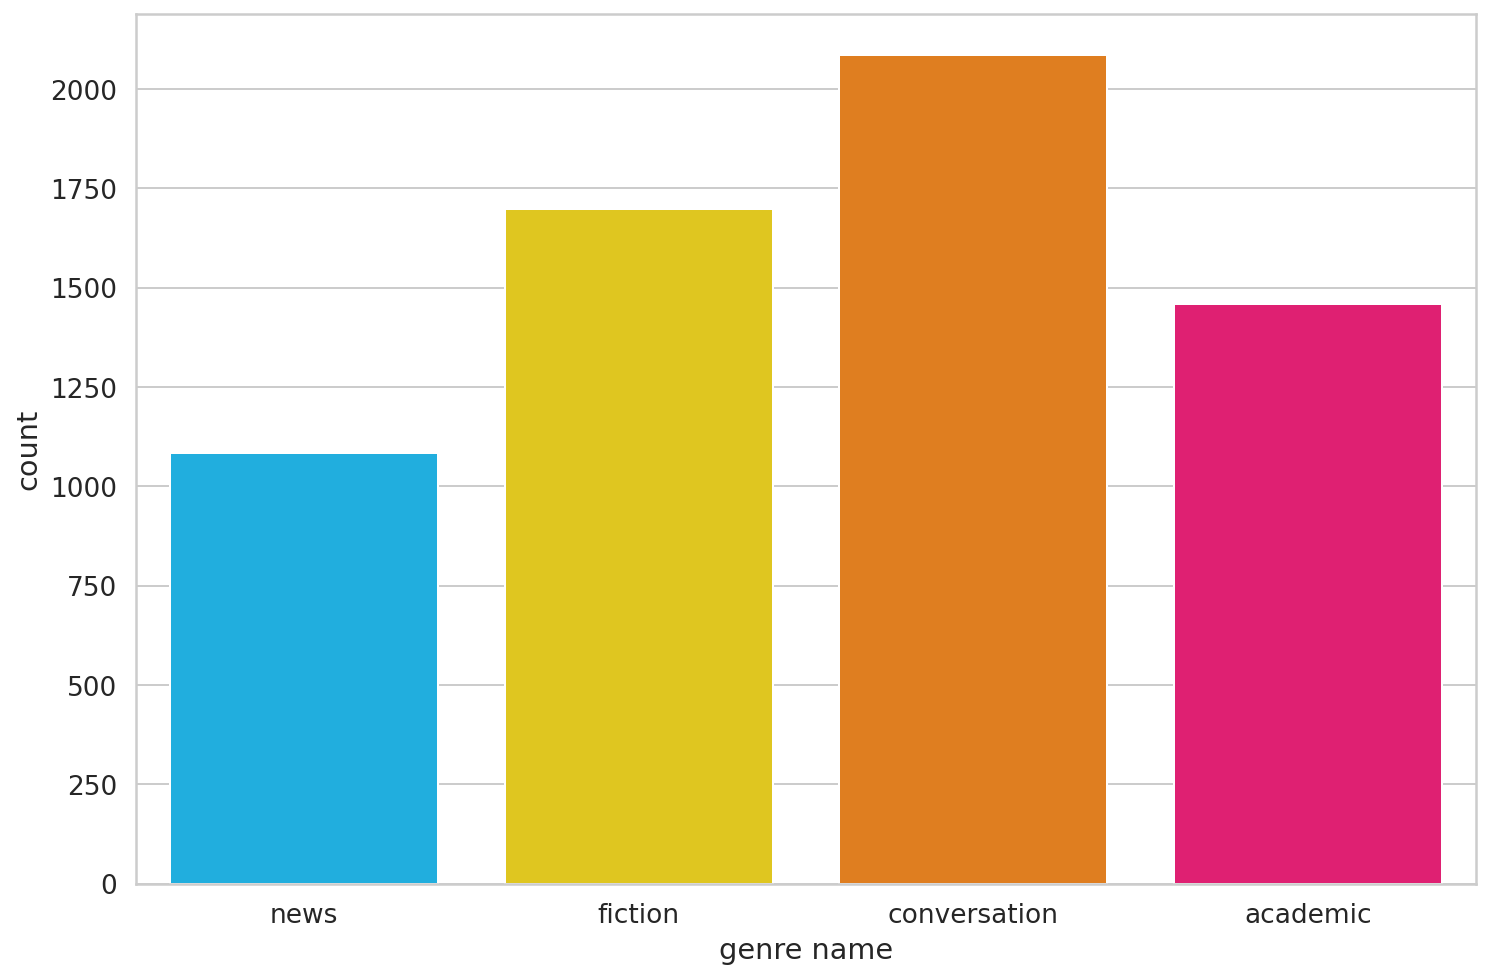

In [ ]:
ax = sns.countplot(df.genre_mc)
plt.xlabel('genre name')
ax.set_xticklabels(class_names);

In [ ]:
df.head()

,txt_id,sen_ix,sentence,label_seq,pos_seq,labeled_sentence,genre,genre_mc
0,a1k-fragment02,41,Ca n't fail to be entertaining .,"[0, 0, 0, 0, 0, 0, 0]","['VERB', 'ADV', 'VERB', 'PART', 'VERB', 'ADJ',...",Ca n't fail to be entertaining .,news,0
1,cdb-fragment04,907,How much was he going to tell her ?,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","['ADV', 'ADJ', 'VERB', 'PRON', 'VERB', 'PART',...",How much was he going to tell her ?,fiction,1
2,ac2-fragment06,1520,"Up until that news hit the Committee , Don had...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","['ADP', 'ADP', 'DET', 'NOUN', 'VERB', 'DET', '...","Up until M_that news M_hit the Committee , Don...",fiction,1
3,kbc-fragment13,5871,Could go on to the rugby and go with them coul...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","['VERB', 'VERB', 'PART', 'ADP', 'DET', 'NOUN',...",Could go on to the rugby and go with them coul...,conversation,2
4,ahb-fragment51,734,"Finally , we went to the office and they gave ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","['ADV', 'PUNCT', 'PRON', 'VERB', 'ADP', 'DET',...","Finally , we went to the office and M_they M_g...",news,0


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
token_lens = []

for txt in df.sentence:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


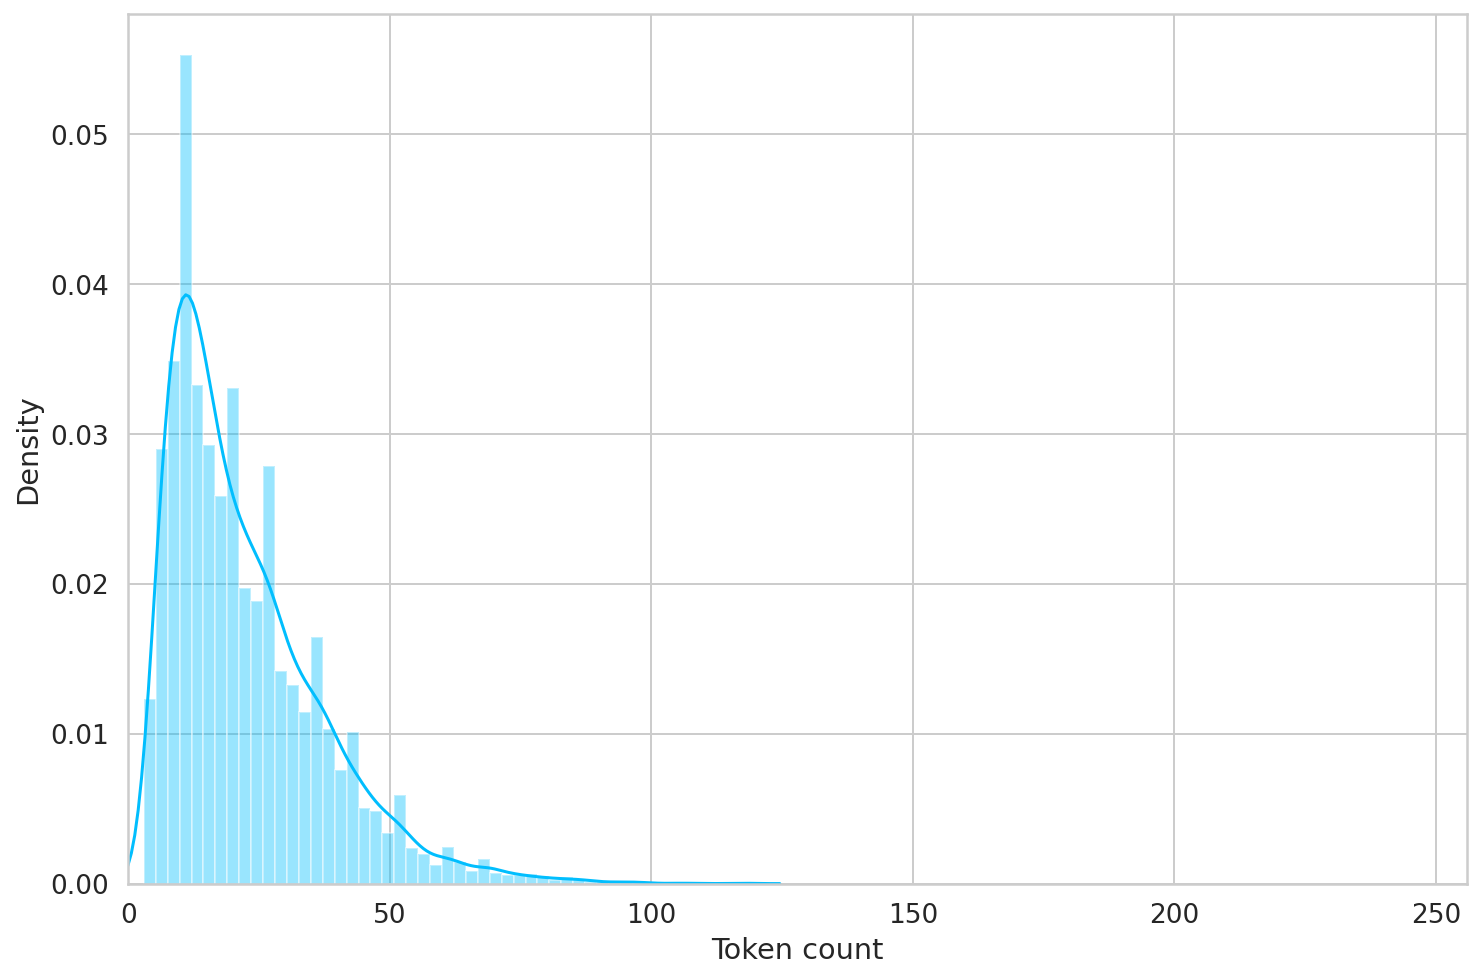

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 100

In [ ]:
# Pytorch dataset

class VuaDataset(Dataset):

  def __init__(self, sentences, targets, tokenizer, max_len):
    self.sentences = sentences
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sentences)
  
  def __getitem__(self, item):
    sentence = str(self.sentences[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'sentence_text': sentence,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((5690, 8), (316, 8), (317, 8))

In [ ]:
# Dataloader

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = VuaDataset(
    sentences=df.sentence.to_numpy(),
    targets=df.genre_mc.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['sentence_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class VuaClassifier(nn.Module):

  def __init__(self, n_classes):
    super(VuaClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.5)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = VuaClassifier(len(class_names))
model = model.to(device)

In [ ]:
# move example batch of our data to GPU

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


In [ ]:
# to get the predicted probabilities from the trained model, apply the softmax function to the outputs

F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3733, 0.3212, 0.1757, 0.1298],
        [0.3053, 0.1679, 0.3972, 0.1296],
        [0.4276, 0.1494, 0.1989, 0.2241],
        [0.5672, 0.1683, 0.1189, 0.1456],
        [0.2481, 0.4455, 0.1619, 0.1446],
        [0.3926, 0.1618, 0.2630, 0.1825],
        [0.2710, 0.3791, 0.1903, 0.1595],
        [0.4679, 0.2154, 0.2380, 0.0786],
        [0.3456, 0.1483, 0.4143, 0.0918],
        [0.3267, 0.2035, 0.3406, 0.1291],
        [0.2330, 0.1869, 0.4978, 0.0823],
        [0.4633, 0.2061, 0.2300, 0.1005],
        [0.2477, 0.2462, 0.3842, 0.1219],
        [0.3439, 0.2385, 0.2863, 0.1314],
        [0.3458, 0.1935, 0.2078, 0.2529],
        [0.4066, 0.1585, 0.2280, 0.2069]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [ ]:
# training

EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.5377175127564187 accuracy 0.798066783831283
Val   loss 0.3737687749788165 accuracy 0.8734177215189873

Epoch 2/3
----------
Train loss 0.1927696958209095 accuracy 0.9400702987697716
Val   loss 0.4038706133607775 accuracy 0.8987341772151899

Epoch 3/3
----------
Train loss 0.07809703787095489 accuracy 0.9796133567662566
Val   loss 0.45258379585575315 accuracy 0.8987341772151899

CPU times: user 3min 25s, sys: 1min 58s, total: 5min 24s
Wall time: 5min 33s


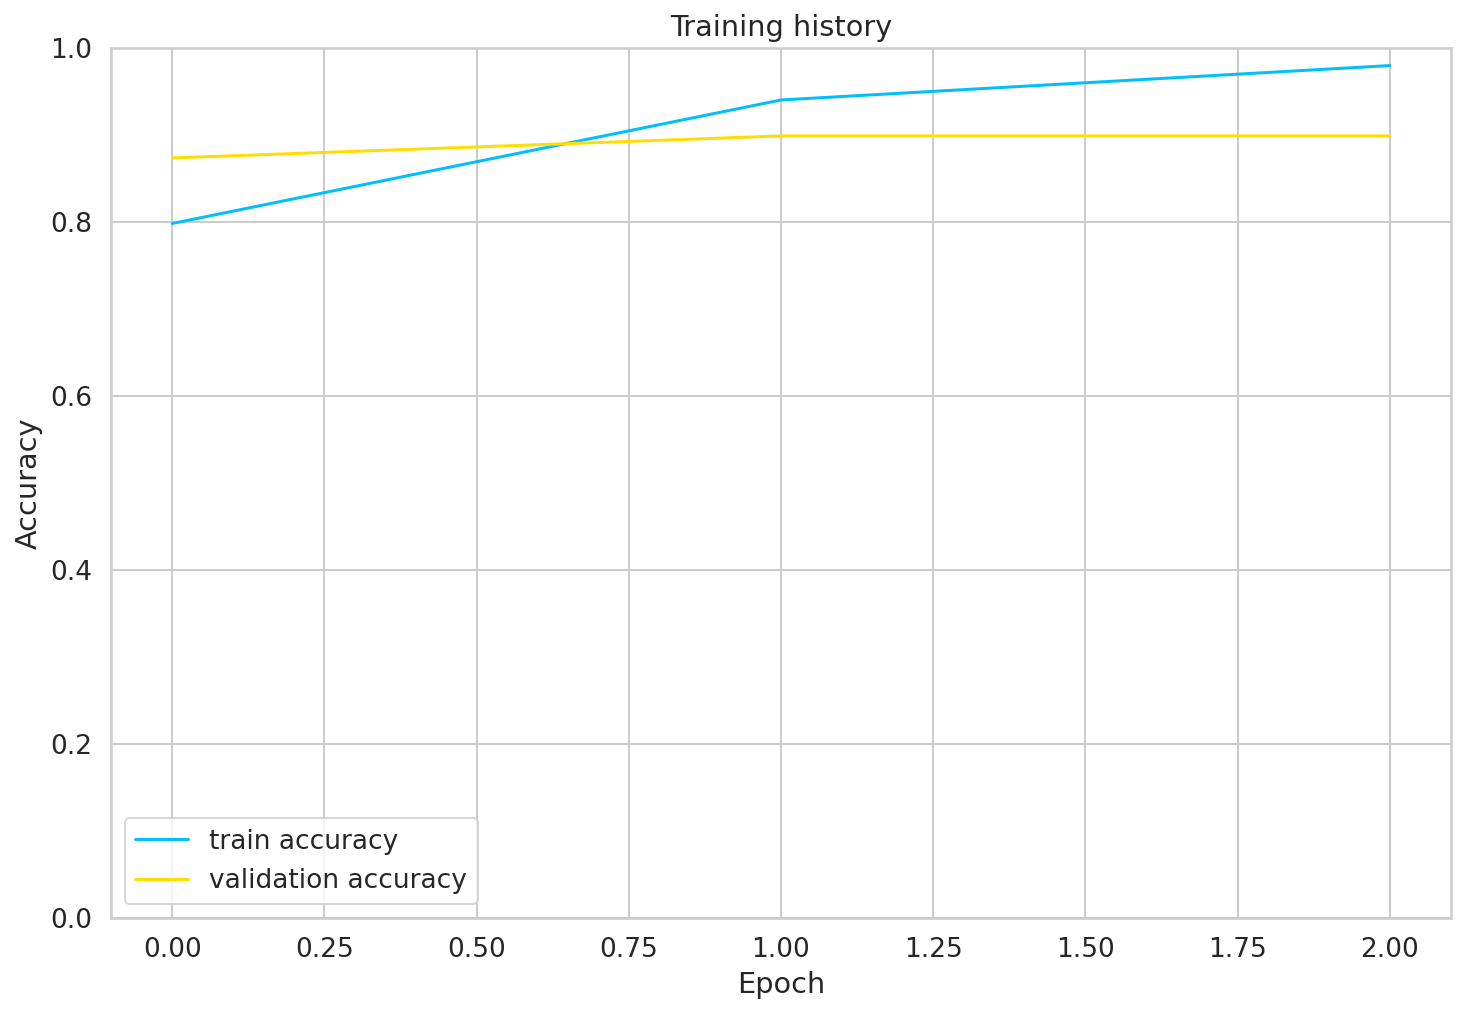

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8580441640378549

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  sentence_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["sentence_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      sentence_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence_texts, predictions, prediction_probs, real_values

In [ ]:
y_sentence_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        news       0.78      0.71      0.74        49
     fiction       0.82      0.78      0.80        83
conversation       0.88      0.93      0.90       107
    academic       0.90      0.94      0.92        78

    accuracy                           0.86       317
   macro avg       0.85      0.84      0.84       317
weighted avg       0.86      0.86      0.86       317



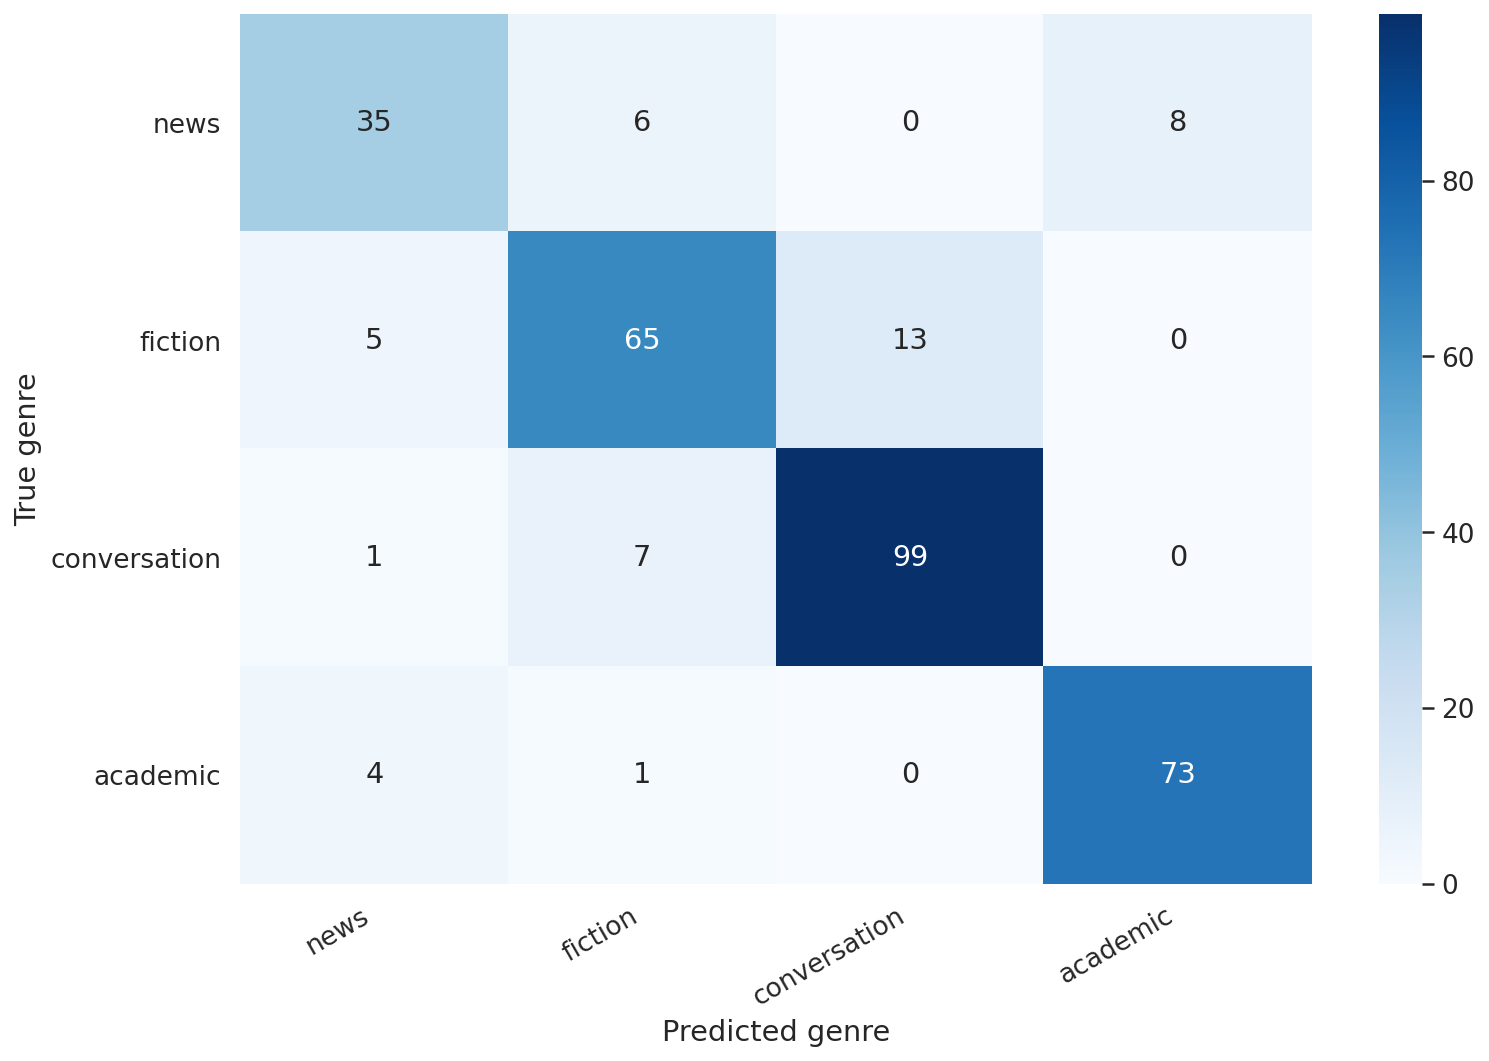

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True genre')
  plt.xlabel('Predicted genre');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

sentence_text = y_sentence_texts[idx]
true_genre = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(sentence_text)))
print()
print(f'True genre: {class_names[true_genre]}')

Well the the hotel we are going to stay

True genre: conversation


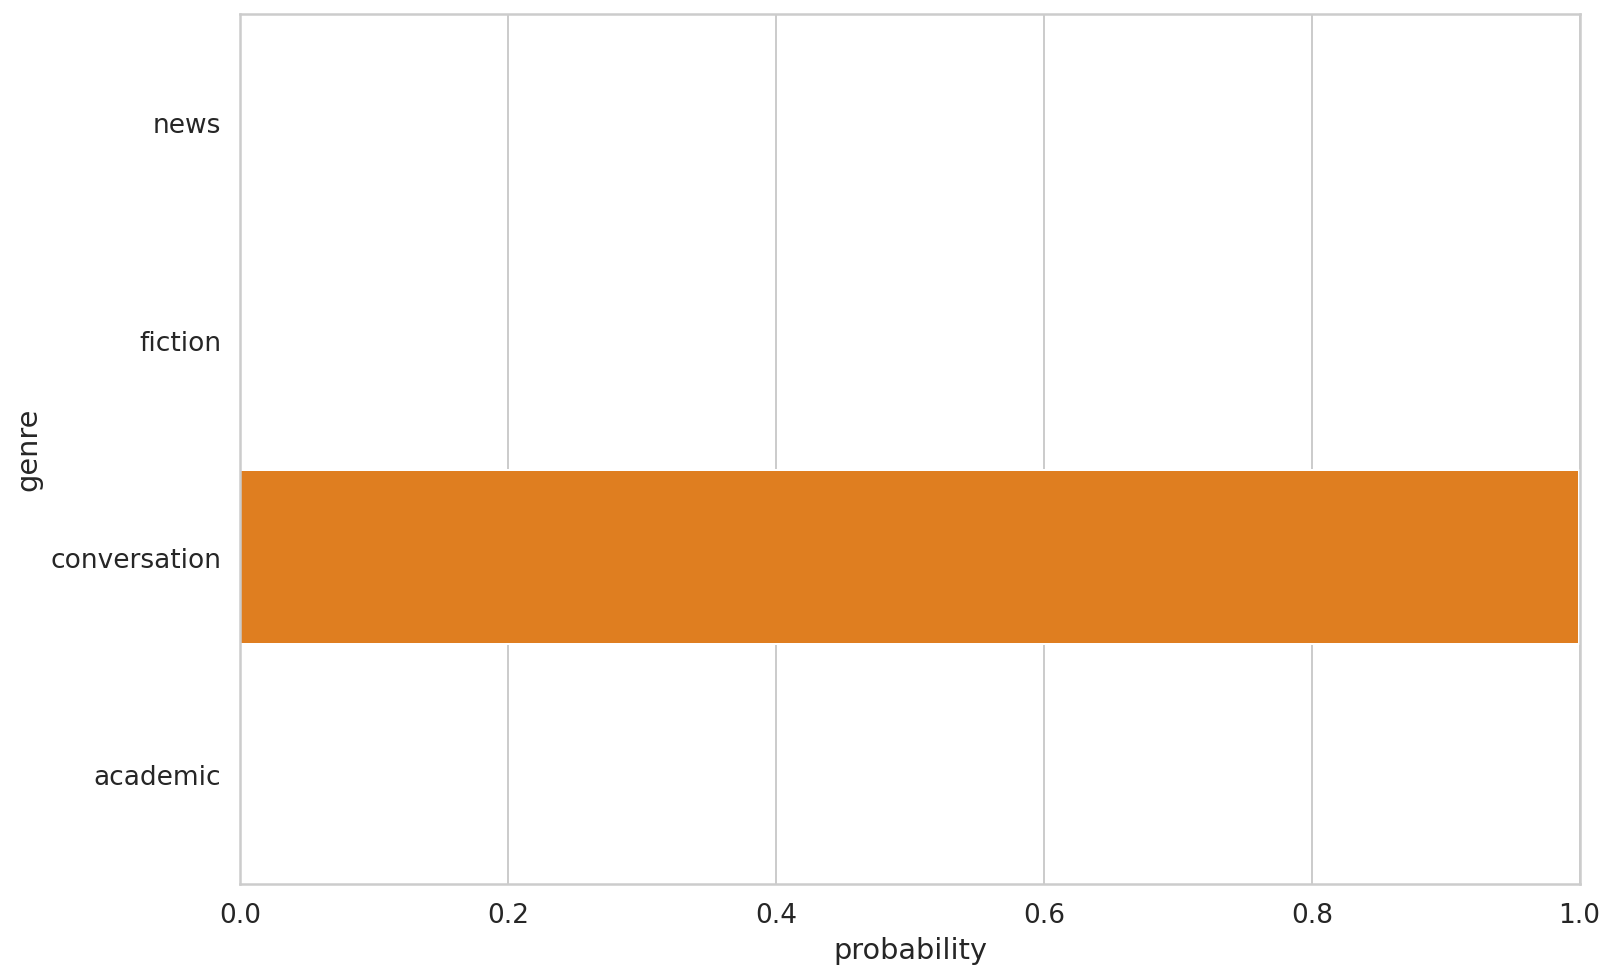

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('genre')
plt.xlabel('probability')
plt.xlim([0, 1]);

#Predicting on raw text

##VUAsequence test set - news. not present in train data

In [ ]:
#news
raw_text = "Sleek , solidly built , gentle on the environment , they are often an ideal form of city transport ."

In [ ]:
encoded_text = tokenizer.encode_plus(
  raw_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Raw text: {raw_text}')
print(f'British National Corpus Genre: {class_names[prediction]}')

Raw text: Sleek , solidly built , gentle on the environment , they are often an ideal form of city transport .
British National Corpus Genre: academic


In [ ]:
#conversation
raw_text2 = "Well that , but your main areas will be gon na be before ."

In [ ]:
encoded_text2 = tokenizer.encode_plus(
  raw_text2,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_text2['input_ids'].to(device)
attention_mask = encoded_text2['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Raw text: {raw_text2}')
print(f'British National Corpus Genre: {class_names[prediction]}')

Raw text: Well that , but your main areas will be gon na be before .
British National Corpus Genre: conversation


In [ ]:
#fiction
raw_text3 = "I had no idea , Paula said , surprised she had not already heard the news ."

In [ ]:
encoded_text3 = tokenizer.encode_plus(
  raw_text3,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_text3['input_ids'].to(device)
attention_mask = encoded_text3['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Raw text: {raw_text3}')
print(f'British National Corpus Genre: {class_names[prediction]}')

Raw text: I had no idea , Paula said , surprised she had not already heard the news .
British National Corpus Genre: fiction


In [ ]:
#academic
raw_text4 = "Consequently , very few girls at the foreclosure stage will enter science unless they receive considerable encouragement and a model to do so from their parents and their school ."

In [ ]:
encoded_text4 = tokenizer.encode_plus(
  raw_text4,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_text4['input_ids'].to(device)
attention_mask = encoded_text4['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Raw text: {raw_text4}')
print(f'British National Corpus Genre: {class_names[prediction]}')

Raw text: Consequently , very few girls at the foreclosure stage will enter science unless they receive considerable encouragement and a model to do so from their parents and their school .
British National Corpus Genre: academic
